# CNN

In this notebook, we will go through basics of CNN using MNIST dataset. 

Here we will use [Tensorflow](https://www.tensorflow.org/ "Tensorflow Homepage").

Hey yo, but what is CNN? 

Everything is explained in-detail in [blog post](dudeperf3ct.github.io). This is notebook which replicates the result of blog and runs in colab. Enjoy!


#### Run in Colab

You can run this notebook in google colab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)


In [0]:
# load all the required libraries

import numpy as np                                    # package for computing
from sklearn.model_selection import train_test_split  # split dataset
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf                                          # import keras with tensorflow as backend


import matplotlib.pyplot as plt             # matplotlib library for plotting

# display plots inline (in notebook itself)
%matplotlib inline                          

## MNIST Dataset


 
The [MNIST dataset](http://yann.lecun.com/exdb/mnist/) of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples each of size 28 x 28 pixels. The digits have been size-normalized and centered in a fixed-size image.

It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. 

Here is one example from dataset




In [2]:
# load mnist data

# the data, split between train and validation sets
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

# As image is grayscale it has values from [0-255] which we will visualize below
# convert dtype to float32 and scale the data from [0-255] to [0-1]
train_x = train_x.astype('float32')
test_x = test_x.astype('float32')
train_x /= 255
test_x /= 255

print('Training samples and shape:', train_x.shape[0], train_x.shape)
print('Test samples and shape:', test_x.shape[0], test_x.shape)

Training samples and shape: 60000 (60000, 28, 28)
Test samples and shape: 10000 (10000, 28, 28)


In [3]:
# we will split val into --> 20% val set and 80% test set 
# stratify ensures the distribution of classes is same in both the sets

val_x, test_x, val_y, test_y = train_test_split(test_x, test_y, test_size=0.8, stratify=test_y)

print ('Validation samples and shape', val_x.shape[0], val_x.shape)
print ('Test samples and shape', test_x.shape[0], test_x.shape)

Validation samples and shape 2000 (2000, 28, 28)
Test samples and shape 8000 (8000, 28, 28)


## Visualization of data

Enough talk, show me the data!

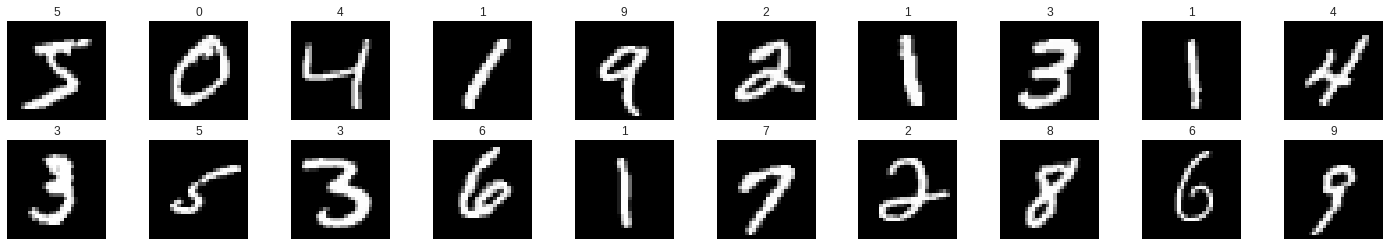

In [4]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(train_x[idx], cmap='gray')
    # print out the correct label for each image
    ax.set_title(str(train_y[idx]))

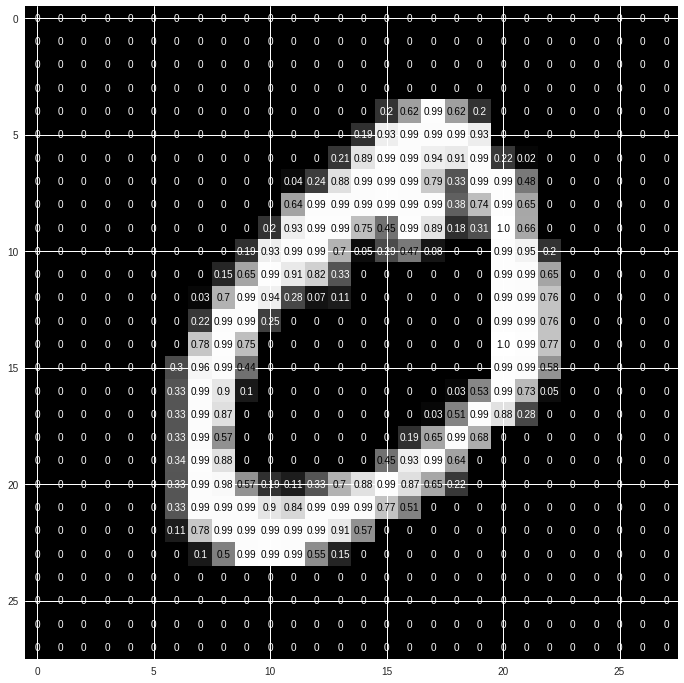

In [5]:
img = train_x[1]

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

## Model

In [0]:
# The MNIST dataset has 10 classes, representing the digits 0 through 9.
NUM_CLASSES = 10
NUM_HIDDEN = 16
BATCH_SIZE = 128
EPOCHS = 2000

# The MNIST images size = 28x28 pixels.
IMAGE_ROWS = 28
IMAGE_COLS = 28
INPUT_SHAPE = (IMAGE_ROWS, IMAGE_COLS, 1)

In [0]:
def model(x):

  with tf.name_scope('reshape'):
    x = tf.reshape(x, [-1, 28, 28, 1])

  # First CONV layer
  with tf.variable_scope('conv1', reuse=tf.AUTO_REUSE):
    conv1 = tf.layers.conv2d(x, 32, 3, activation=tf.nn.relu)
    
  # Second fully connected net
  with tf.variable_scope('conv2', reuse=tf.AUTO_REUSE):
    conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)

  with tf.variable_scope('pool1', reuse=tf.AUTO_REUSE):
    conv2 = tf.layers.max_pooling2d(conv2, 2, 2)
  
  with tf.variable_scope('dropout', reuse=tf.AUTO_REUSE):
    h_drop1 = tf.layers.dropout(conv2, rate=0.25)
    
  with tf.variable_scope('flatten', reuse=tf.AUTO_REUSE):
    h_flat = tf.layers.flatten(h_drop1)
    
  with tf.variable_scope('fc1', reuse=tf.AUTO_REUSE):
    h_fc1 = tf.layers.dense(h_flat, 128)
    
  with tf.variable_scope('dropout', reuse=tf.AUTO_REUSE):
    h_drop2 = tf.layers.dropout(h_fc1, rate=0.5)  

  with tf.variable_scope('fc2', reuse=tf.AUTO_REUSE):
    logits = tf.nn.softmax(tf.layers.dense(h_drop2, NUM_CLASSES))
  
  return logits 

In [0]:
x = tf.placeholder(tf.float32, [None, 784])
y_labels = tf.placeholder(tf.int64, [None])

y = model(x)

# Loss, optimizer and trainer
with tf.name_scope('loss'):
  cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=y_labels, logits=y)
cross_entropy = tf.reduce_mean(cross_entropy)

with tf.name_scope('adam_optimizer'):
  train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)

# Accuracy 
with tf.name_scope('accuracy'):
  correct_prediction = tf.equal(tf.argmax(y, 1), y_labels)
  correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

In [11]:
mnist = input_data.read_data_sets('.') 
sess = tf.Session()
tf.global_variables_initializer().run(session=sess)
for i in range(EPOCHS):
  batch = mnist.train.next_batch(BATCH_SIZE)
  sess.run([train_step], feed_dict={x: batch[0], y_labels: batch[1]})

  if i % 100 == 0:
    train_accuracy = accuracy.eval(feed_dict={x: batch[0], y_labels: batch[1]}, session=sess)
    print('step %d, training accuracy %g' % (i, train_accuracy))

print('test accuracy %g' % accuracy.eval(feed_dict={
    x: mnist.test.images, y_labels: mnist.test.labels}, session=sess))

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
step 0, training accuracy 0.289062
step 100, training accuracy 0.882812
step 200, training accuracy 0.976562
step 300, training accuracy 0.984375
step 400, training accuracy 0.960938
step 500, training accuracy 0.945312
step 600, training accuracy 0.976562
step 700, training accuracy 0.96875
step 800, training accuracy 0.984375
step 900, training accuracy 0.992188
step 1000, training accuracy 0.

## Result

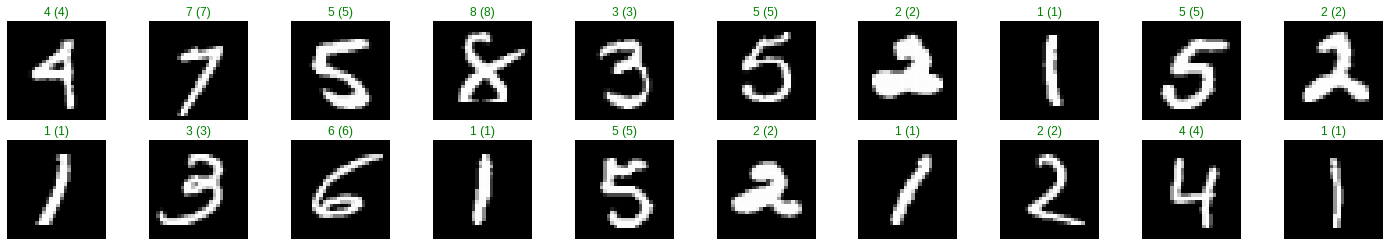

In [12]:
# obtain one batch of test images
images, labels = test_x[:32], test_y[:32]

# get sample outputs
predict = model(images)
# convert output probabilities to predicted class
pred = predict.eval(session=sess)
preds = np.argmax(pred, axis=1)

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(images[idx].reshape(28, 28), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx]), str(labels[idx])),
                 color=("green" if preds[idx]==labels[idx] else "red"))

Text(0.5,1,'100.00 % accuracy')

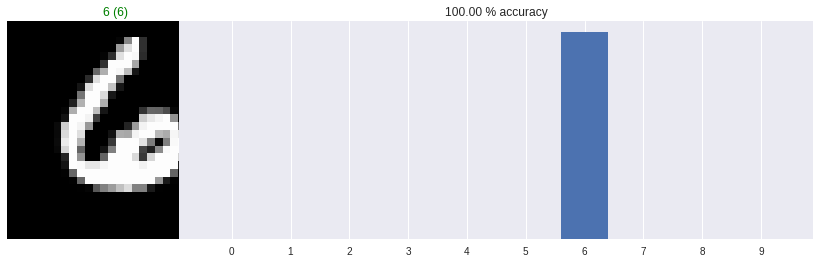

In [15]:
import random

random_idx = random.randint(0, len(test_x))

# get sample outputs
predict = model(test_x[None, random_idx])
# convert output probabilities to predicted class
pred = predict.eval(session=sess)
preds = np.argmax(pred, axis=1)


# plot the images one example, along with predicted and true labels and probabilities
fig = plt.figure(figsize=(25, 4))
ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
ax.imshow(test_x[random_idx].reshape(28, 28), cmap='gray')
ax.set_title("{} ({})".format(str(preds[0]), str(test_y[random_idx])),
             color=("green" if preds[0]==test_y[random_idx] else "red"))
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
x_labels = np.arange(10)
ax.bar(np.arange(10), height=np.squeeze(pred), tick_label=x_labels)
ax.set_title("{:.2f} % accuracy".format(float(np.max(pred, axis=1)*100)))